### Домашнее задание к лекции «Поиск выбросов и генерация новых признаков»

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

In [2]:
data = pd.read_csv('train.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Подготовка данных

In [3]:
# колонку ID можно выкинуть, вряд ли она поможет модели
data.drop(['Id'], axis=1, inplace=True)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [5]:
# Так как данных мало, строки из данных выкидывать не будем

In [6]:
# Заменим пропуски
cat_col = [i for i in data.columns if data[i].dtype.name == 'object']
num_col   = [i for i in data.columns if data[i].dtype.name != 'object']

# Заменим строкой категориальные пропущенные признаки
for i in cat_col:
    data[i].fillna('None', inplace=True)
    
# Заменим спец числом дтскретные  признаки
for i in num_col:
    data[i].fillna(-999999, inplace=True)
    
# теперь пропусков отсаться не должно

In [7]:
cat_nunique = data[cat_col].nunique()
cat_nunique

MSZoning          5
Street            2
Alley             3
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          5
BsmtCond          5
BsmtExposure      5
BsmtFinType1      7
BsmtFinType2      7
Heating           6
HeatingQC         5
CentralAir        2
Electrical        6
KitchenQual       4
Functional        7
FireplaceQu       6
GarageType        7
GarageFinish      4
GarageQual        6
GarageCond        6
PavedDrive        3
PoolQC            4
Fence             5
MiscFeature       5
SaleType          9
SaleCondition     6
dtype: int64

In [8]:
# посмотрим на признаки, которые имеют 2 или меньше значений. Может быть они сильно неравномерно распределенны

In [9]:
data.Street.value_counts()

Pave    1454
Grvl       6
Name: Street, dtype: int64

In [10]:
data.Utilities.value_counts()

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

In [11]:
data.CentralAir.value_counts()

Y    1365
N      95
Name: CentralAir, dtype: int64

In [12]:
# Очевидно, что на признаках Utilities модель споткнется, она будут только мешать обучению. Я выкину этотпризнаки как незначащий и имеющий почти всегда одинаковое значение
data.drop(['Utilities'], axis=1, inplace=True)
cat_nunique.drop(['Utilities'], axis=0, inplace=True)

In [13]:
#Чтобы в разы не увеличивать число признаков при построении dummy,
#будем использовать категориальные признаки с < 5 уникальных значений
ohe_col = list(cat_nunique[cat_nunique < 5].index) #для кодировки в onehot
le_col = list(cat_nunique[cat_nunique >= 5].index) #для кодировки в label

In [14]:
LE = LabelEncoder()
for i in le_col:        
    data[i] = LE.fit_transform(data[i])

In [15]:
# Создаем дамми-переменные для категорий
dummy_df = pd.get_dummies(data[ohe_col])

In [16]:
# Объедим
data = pd.concat([data, dummy_df], axis=1)
# дропнем некодированные
data.drop(ohe_col, axis=1,  inplace=True)

In [17]:
# стандартизируем числовые данные
num_col.remove('SalePrice') # кроме целевой переменной
scaler = StandardScaler()
data[num_col] = scaler.fit_transform(data[num_col])

In [18]:
# Получился вот такой датасет для обучения
data

,MSSubClass,MSZoning,LotFrontage,LotArea,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,...,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_None
0,0.073375,3,0.464372,-0.207142,4,5,2,2,0,5,...,0,1,0,0,0,1,0,0,0,1
1,-0.872563,3,0.464411,-0.091886,2,24,1,2,0,2,...,0,1,0,0,0,1,0,0,0,1
2,0.073375,3,0.464380,0.073480,4,5,2,2,0,5,...,0,1,0,0,0,1,0,0,0,1
3,0.309859,3,0.464359,-0.096897,0,6,2,2,0,5,...,0,0,1,0,0,1,0,0,0,1
4,0.073375,3,0.464422,0.375148,2,15,2,2,0,5,...,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.073375,3,0.464364,-0.260560,4,8,2,2,0,5,...,0,1,0,0,0,1,0,0,0,1
1456,-0.872563,3,0.464424,0.266407,4,14,2,2,0,2,...,0,0,1,0,0,1,0,0,0,1
1457,0.309859,3,0.464375,-0.147810,4,6,2,2,0,5,...,0,1,0,0,0,1,0,0,0,1
1458,-0.872563,3,0.464380,-0.080160,4,12,2,2,0,2,...,0,0,1,0,0,1,0,0,0,1


#### Обучение

In [19]:
X = data.drop(['SalePrice'], axis=1)
y = data['SalePrice']

In [20]:
# функция для кросс валидации
def crossValidation(model, X, y):
    kf = KFold(n_splits=10, shuffle=True)
    print(f'Оценка качества кросс валидации: {cross_val_score(model, X, y, cv=kf).mean()}')

In [21]:
# функция оценки качества модели
def show_score_model(model, X_test, y_test, X_train, y_train):
    print(f'Оценка качетсва самой модели (тестовые данные): {model.score(X_test, y_test)}')
    print(f'Оценка качетсва самой модели (тренировочные данные): {model.score(X_train, y_train)}')

In [22]:
# Разобьемданные для обучения и теста
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [23]:
# Случайный лес и оценка качества 
clf_rf = RandomForestRegressor(n_estimators=20, max_depth=5)
clf_rf.fit(X_train, y_train)
crossValidation(clf_rf, X_test, y_test)

Оценка качества кросс валидации: 0.8259862778270654


In [27]:
show_score_model(clf_rf, X_test, y_test, X_train, y_train)

Оценка качетсва самой модели (тестовые данные): 0.8483921284624218
Оценка качетсва самой модели (тренировочные данные): 0.8999088480906254


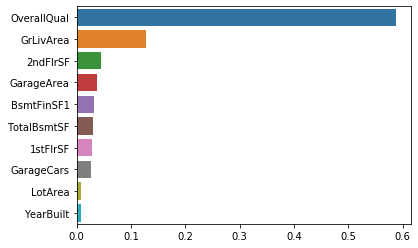

In [28]:
import seaborn as sns
# Определим какие параметры важны (первые 10)
importances = pd.Series(clf_rf.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False, inplace=True)
sns.barplot(x=importances[:10], y=importances[:10].index)

In [29]:
# Cтекинг
stack = StackingRegressor(
    [
        ('svr', SVR()),
        ('linr', LinearRegression()),
        ('dtr', DecisionTreeRegressor())
    ],
)

In [30]:
stack.fit(X_train, y_train)

StackingRegressor(cv=None,
                  estimators=[('svr',
                               SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                   epsilon=0.1, gamma='scale', kernel='rbf',
                                   max_iter=-1, shrinking=True, tol=0.001,
                                   verbose=False)),
                              ('linr',
                               LinearRegression(copy_X=True, fit_intercept=True,
                                                n_jobs=None, normalize=False)),
                              ('dtr',
                               DecisionTreeRegressor(ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=None,
                                                     max_features=None,
                                                     max_leaf_nodes=None,
                                                     min_impu

In [31]:
show_score_model(stack, X_test, y_test, X_train, y_train)

Оценка качетсва самой модели (тестовые данные): 0.8428173643054778
Оценка качетсва самой модели (тренировочные данные): 0.9723315424247655


In [34]:
# как видно выше, стекинг отработал лучше на тренировочных данных, почти идеально (наверное, из-за переобучения дерева), 
# а вот тестовые уже не так хорошо. 

In [35]:
print(f' Качество в стекинге svr: {stack.named_estimators_.svr.score(X_test, y_test)}')
print(f' Качество в стекинге linr: {stack.named_estimators_.linr.score(X_test, y_test)}')
print(f' Качество в стекинге dtr: {stack.named_estimators_.dtr.score(X_test, y_test)}')

 Качество в стекинге svr: -0.041332425414498
 Качество в стекинге linr: 0.8223166587401715
 Качество в стекинге dtr: 0.8134683949511233


In [31]:
# Стекинг обучился лучше на тестовых данных, чем модели по отдельности